# Parametric Survival Fit & PSA for Age-at-Onset in Autoimmune Disease: Generalized Gamma Workflow

## Background and Motivation

In rare disease research, published studies often report aggregate summary statistics (such as quartiles and sample size) rather than individual-level data. Despite this limitation, we can still estimate the underlying age-at-onset distribution using parametric survival models.

In this notebook, we fit parametric models (lognormal, Weibull, and generalized gamma) to reported summary statistics. We then use the best-fitting model to estimate age-band diagnosis proportions and propagate parameter uncertainty using probabilistic sensitivity analysis (PSA).

This approach is commonly used in epidemiological modeling and health economic models, where understanding the distribution of disease onset is essential for estimating clinical burden, quality-adjusted life years, and cost trajectories.

## Software and Dependencies


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, weibull_min, gamma, genextreme # Importing necessary libraries for statistical distributions 
from scipy.optimize import minimize # Optimization for parameter fitting
from scipy.stats import probplot # Probability plot for visual assessment
from sklearn.metrics import mean_squared_error # Mean Squared Error for goodness-of-fit
from scipy.stats import gaussian_kde # Kernel Density Estimation for smooth CDF
from scipy.stats import gengamma
from scipy.stats import gengamma, norm

### Step 1: Fit Parametric Age-at-Onset Model

### 1. Inputs & Assumptions

The summary statistics derived from literature informed three parametric survival model, consisting of log normal, weibull and generalized gamma. Of them, generalized gamma has the optimal fit of goodness, with lowest AIC. For patient privacy consideration, only aggregate level data is often reported in literature in the rare disease field.

For better transparency and reproducibility, this section presents the procedure to achive the fitted generalized gamma, with fitted parameters, while skipping show details to perform fitting for other two models, and model performance comparison. The detailed steps can be found in my blog article. 

In [2]:
median = 66
q1 = 61 
q3 = 72
min = 19
max = 88
mean = 67
size = 111

empirical_q = [q1, median, q3]

In [3]:
# Overview of the input data
data_summary = pd.DataFrame({
    'Statistic': ['Min', 'Q1', 'Median', 'Q3', 'Max', 'Mean', 'Size'],
    'Value': [min, q1, median, q3, max, mean, size]
})
print(data_summary)

  Statistic  Value
0       Min     19
1        Q1     61
2    Median     66
3        Q3     72
4       Max     88
5      Mean     67
6      Size    111


The above table summarizes six points quantiles reported in the article, as well as sample size.

### 2. Generalized Gamma: Parameter Estimation via Quantile Matching

Apply quantile matching method to seek for the optimal model with smallest difference between predicted and observed quantiles.

The generalized Gamma distribution has three parameters to fit:
- a: shape parameter
- c: power parameter
- scale: scale parameter

In [4]:
# Define the quantile-matching objective function
def gengamma_objective(params):
    a, c, scale = params
    if a <= 0 or scale <= 0:
        return np.inf
    try:
        dist = gengamma(a=a, c=c, scale=scale)
        theo_q = dist.ppf([0.25, 0.5, 0.75])
        return np.sum((np.array(theo_q)- np.array(empirical_q))**2)
    except:
        return np.inf

In [5]:
# Run the optimization
initial_guess_gengamma = [2.0, 1.0, 10.0]
bounds_gengamma = [(0.01, None), (0.01, None), (0.01, None)]

result_gengamma = minimize(gengamma_objective, x0=initial_guess_gengamma, bounds=bounds_gengamma)
a_fit_gengamma, c_fit_gengamma, scale_fit_gengamma = result_gengamma.x


/var/folders/b8/9ymtxc2j7rb00xx34s753cwc0000gn/T/ipykernel_72089/1451994867.py:9: RuntimeWarning: overflow encountered in square
  return np.sum((np.array(theo_q)- np.array(empirical_q))**2)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [6]:

print(f"Fitted Generalized Gamma parameters: a={a_fit_gengamma}, c={c_fit_gengamma}, scale={scale_fit_gengamma}")

Fitted Generalized Gamma parameters: a=26.611036258227774, c=1.5834959593234883, scale=8.40915196992153


### 3. Model Fit Diagnostics

Inspect visually whether simulated distribution match reasonably with observed samples.

In [7]:
# Simulate onset ages 
sim_ages_gengamma = gengamma(a = a_fit_gengamma, c = c_fit_gengamma, scale = scale_fit_gengamma).rvs(10000)

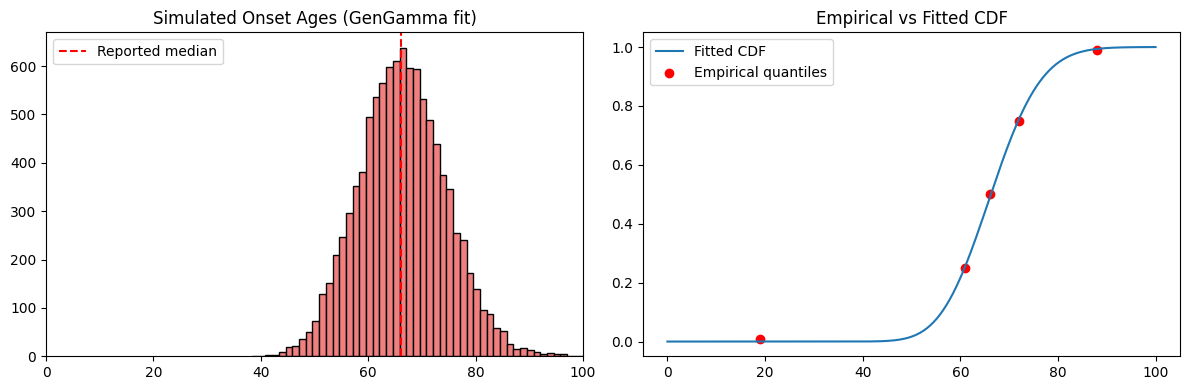

In [8]:
# Plot histogram and CDF
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

# Histogram
ax[0].hist(sim_ages_gengamma, bins=50, color='lightcoral', edgecolor='black')
ax[0].axvline(x=median, color='red', linestyle='--', label='Reported median')
ax[0].set_title('Simulated Onset Ages (GenGamma fit)')
ax[0].set_xlim(0, 100)
ax[0].legend()

# CDF
x_gengamma = np.linspace(0, 100, 300)
model_cdf_gengamma = gengamma(a=a_fit_gengamma, c=c_fit_gengamma, scale=scale_fit_gengamma).cdf(x_gengamma)
ax[1].plot(x_gengamma, model_cdf_gengamma, label='Fitted CDF')
ax[1].scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical quantiles')
ax[1].set_title('Empirical vs Fitted CDF')
ax[1].legend()

plt.tight_layout()
plt.show()


The left subplot illusrates simulated distribution with a reference line being the observed (reported) median. In addition, the right subplot illusrates simulated cumulative distribution function mapping with reported quantiles.

## Step 2: Probabilistic Sensitivity Analysis (PSA)

### 4. PSA Setup: Variance-Covariance, MVN Sampling, and Constraint

Multivariate normal sampling is used to draw plausible random values of individual parameters, following covariance constraints with the fitted Generalized Gamma model.

Monte Carlo simulation using fitted distribution parameters offers three key advantages:

- Continuous uncertainty representation rather than relying on only low, central, and high values.
- Faster and smoother calculations through the cumulative distribution function (CDF), without the need for inner resampling.
- More stable confidence intervals and compatibility with tornado analysis for identifying key drivers.

In [9]:
# The fitted model object from previous analysis
result_gengamma

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.10243077858152738
        x: [ 2.661e+01  1.583e+00  8.409e+00]
      nit: 88
      jac: [-1.463e-02  1.069e+00 -8.571e-02]
     nfev: 456
     njev: 114
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [10]:
# Get the MLE
theta_hat = result_gengamma.x

print(theta_hat)

[26.61103626  1.58349596  8.40915197]


Compute the Hessian numerically at the optimum

In [11]:
import numpy as np
from statsmodels.tools.numdiff import approx_hess

H = approx_hess(theta_hat, gengamma_objective)  # by default, central differences

In [12]:
# Invert the Hessian to get the variance-covariance matrix
vcov_matrix = np.linalg.inv(H)

print(vcov_matrix)

[[ 5.95129550e+02 -1.77608293e+01 -3.15062237e+02]
 [-1.77608293e+01  5.51055889e-01  9.63377691e+00]
 [-3.15062237e+02  9.63377691e+00  1.69340808e+02]]


In [13]:
# Multivariate normal sampling on fitted scale

from numpy.random import default_rng
rng = default_rng(123)
N = 5000

m = theta_hat  # MLE parameter vector
L = np.linalg.cholesky(vcov_matrix)  # Cholesky decomposition of variance-covariance matrix
Z = rng.standard_normal((N, len(m)))  # Standard normal samples

theta_draws = m + Z @ L.T  # MVN samples of parameters
mu_draws, log_sigma_draws, Q_draws = theta_draws.T

In [14]:
np.mean(log_sigma_draws)

1.5637918813315672

### 5. Age-Band Probabilities and Uncertainty Estimates

The proportion of diease diganosis at pre-defined age bands is the key output of our interest. 

The uncertainty of model parameters, for example a, c, and scale of the Generalized Gamma model, often significantly influence the output of interest, in epidmioology or cost-effectiveness analysis.

Therefore, we investigate age-band-specific proportions according to MVN generated model's parameters. By the end of this section, we caculate mean, SD; and median and 95% confifence interval for the simulated diagnosis prorptions.

We are interested in diagnosis proportion for three specific age groups, 0-12, 12-17, and 18 above years old.

In [15]:
# Age bands (inclusive of lower, exclusive of upper)
age_bands = [(0, 12), (12, 18), (18, 100)]

Instead of iterative sampling from the survival distributions, we employ the cumulative distribution function (CDF) to obtain the proportions falling within three predefined. With using CDF, the computational resouces and time is saved. 

In [16]:
# Compute band probabilities for each parameter set via CDF
def band_probs_for_draw(a, c, s):
    F = gengamma(a=a, c=c, scale=s).cdf
    p0_12 = F(12.0) - F(0.0)
    p12_18 = F(18.0) - F(12.0)
    p18_100 = F(100.0) - F(18.0)
    return p0_12, p12_18, p18_100

In [17]:
P = np.array([band_probs_for_draw(a, c, s) for a, c, s in zip(mu_draws, log_sigma_draws, Q_draws)]) # Shape (N, 3)


In [18]:
# Filter out NaNs in all three columns
P = P[~np.isnan(P).any(axis=1)]

In [19]:
print(P[:10])

[[1.20059387e-02 7.33904212e-02 9.14603640e-01]
 [1.08145832e-25 8.45280534e-18 9.99985839e-01]
 [1.92092384e-12 1.54251855e-08 9.99999974e-01]
 [1.20756676e-18 5.23993223e-13 9.99994565e-01]
 [1.70337946e-27 3.55365476e-19 9.99994112e-01]
 [3.04377245e-19 1.99256162e-13 9.99996554e-01]
 [1.00000000e+00 2.01283434e-13 0.00000000e+00]
 [8.17154984e-16 4.93084700e-11 9.99937577e-01]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.02810919e-20 2.75611355e-14 9.99997395e-01]]


The list includes diagnosis proportions of individual defined age bands, for 5000 interative simulations based sampled pairs of fitted model paramters.

Based on 5000 simulations, calculate 95% confidence interval, as well as other aggregated summary.

In [20]:
# Summarize reults
summary = pd.DataFrame({
    'Age Band': ['0-12', '12-18', '18+'],
    'Mean': np.char.mod('%.2f%%', P.mean(axis=0)*100),
    "SD": np.char.mod('%.2f%%', P.std(axis=0)*100),
    "Median": np.char.mod('%.2f%%', np.median(P, axis=0)*100),
    "CI Lower (2.5%)": np.char.mod('%.2f%%', np.percentile(P, 2.5, axis=0)*100),
    "CI Upper (97.5%)": np.char.mod('%.2f%%', np.percentile(P, 97.5, axis=0)*100)
})

print(summary)


  Age Band    Mean      SD   Median CI Lower (2.5%) CI Upper (97.5%)
0     0-12   2.67%  14.00%    0.00%           0.00%           44.47%
1    12-18   1.95%   9.41%    0.00%           0.00%           23.81%
2      18+  95.38%  18.45%  100.00%           9.54%          100.00%


The table shows median and 95% CI, 0.00% (0.00% - 44.47%), 0.00% (0.00% - 23.81%) and 100.00% (9.54% - 100.00%) for 0-12 years, 12-18, and 18-100 years, respectively.

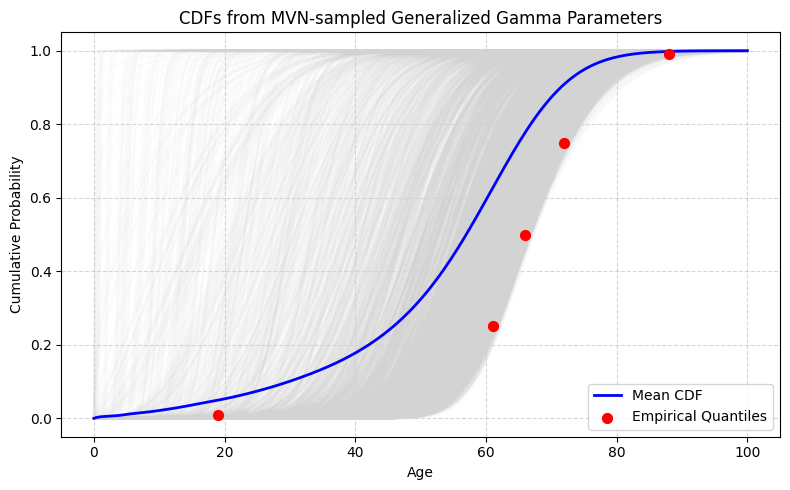

In [30]:
# Draw CDF for sampled parameters
x = np.linspace(0, 100, 300)
cdf_samples = [gengamma(a=a, c=c, scale=s).cdf(x) for a, c, s in zip(mu_draws, log_sigma_draws, Q_draws)]
import matplotlib.pyplot as plt
# Plot sampled CDFs
plt.figure(figsize=(8, 5))
for cdf in cdf_samples:
    plt.plot(x, cdf, color='lightgray', alpha=0.05)

# Plot mean CDF
mean_cdf = np.nanmean(cdf_samples, axis=0)
plt.plot(x, mean_cdf, color='blue', label='Mean CDF', linewidth=2)

# Plot empirical quantiles
plt.scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical Quantiles',
            zorder=10, s=50)

# Format plot
plt.title('CDFs from MVN-sampled Generalized Gamma Parameters')
plt.xlabel('Age')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Software Versions for Reproducibility

Outlined the operation system, Python, and software versions used in this notebook for your better reproducibility.

In [22]:
import sys
import platform
import numpy as np
import pandas as pd
import scipy
import statsmodels
import matplotlib

print("Python:", sys.version.split()[0])
print("Platform:", platform.system(), platform.release())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("SciPy:", scipy.__version__)
print("Statsmodels:", statsmodels.__version__)
print("Matplotlib:", matplotlib.__version__)

Python: 3.12.2
Platform: Darwin 24.6.0
NumPy: 1.26.4
Pandas: 2.2.3
SciPy: 1.13.1
Statsmodels: 0.14.2
Matplotlib: 3.9.2
